<a target="_blank" href="https://colab.research.google.com/github/leonardocrociani/Intelligent-Systems-For-Pattern-Recognition/blob/main/time-series-analysis.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# ISPR - Midterm 1 - Assignment 1: time series analysis.

I have aimed to make the code as self-explanatory as possible. The notebook includes both code and markdown explanations where necessary. I hope the work meets the requirements! 🙂

In [1]:
import pmdarima as pm
from ucimlrepo import fetch_ucirepo
import datetime as dt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [ ]:
appliances_energy_prediction = fetch_ucirepo(id=374) 
dates = appliances_energy_prediction.data.features['date']
series = appliances_energy_prediction.data.targets 

In [3]:
dates = pd.to_datetime(dates, format='%Y-%m-%d%H:%M:%S')

In [4]:
ts = series.merge(dates, left_index=True, right_index=True).set_index('date')

<Axes: xlabel='date'>

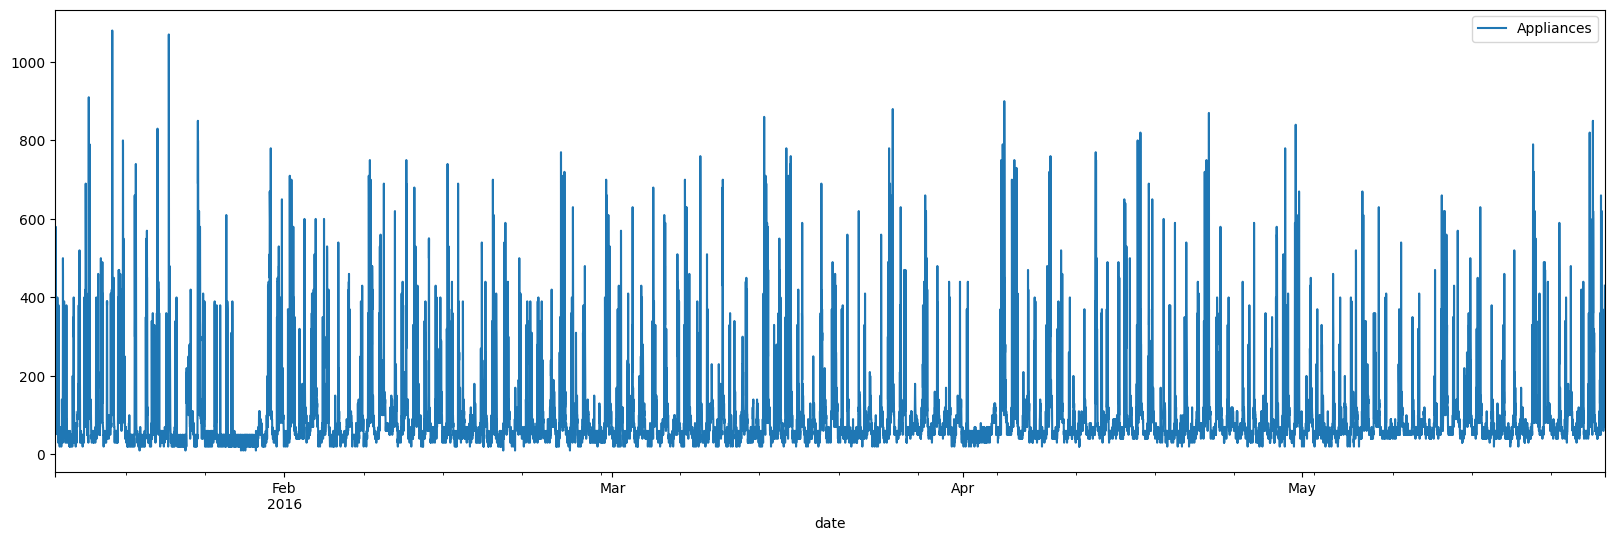

In [5]:
ts.plot(figsize=(20, 6))

The series appears to be stationary, but let's confirm with a statistical test.

In [8]:
result = adfuller(ts['Appliances'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -21.61637819803621
p-value: 0.0
Critical Values:
	1%: -3.430681600227742
	5%: -2.8616865555329394
	10%: -2.566848007525354


Since the p-value is 0.0, we can confidently conclude that the time series is stationary.

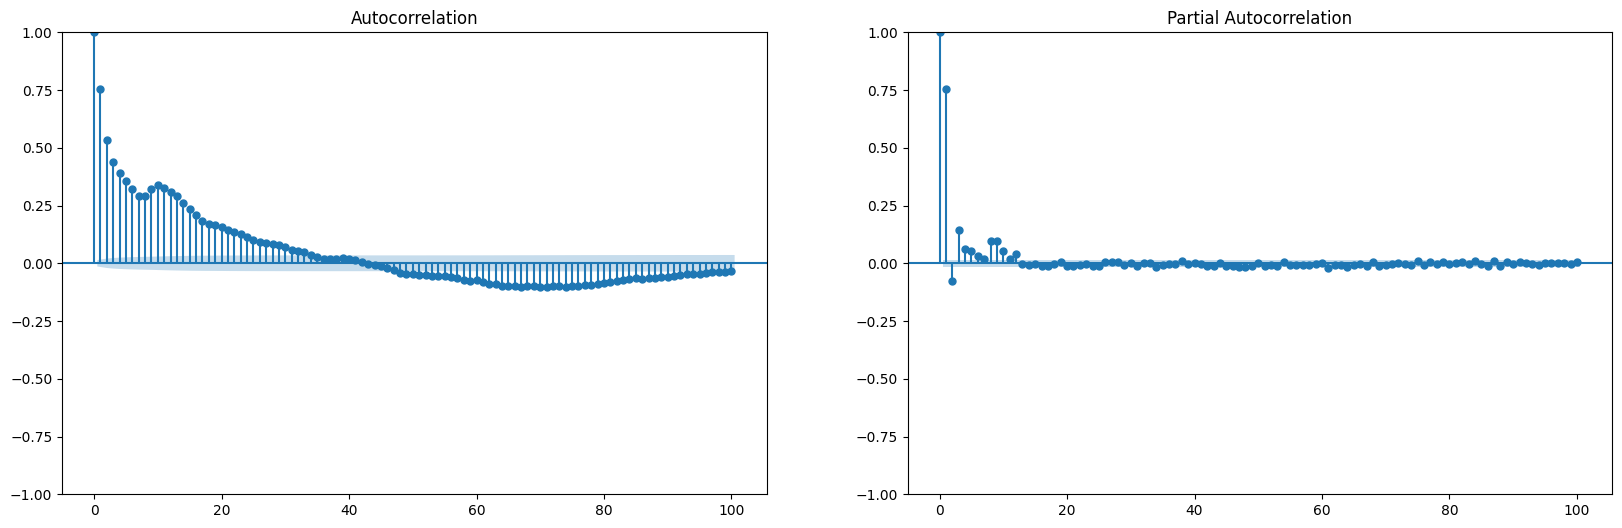

In [19]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_acf(ts['Appliances'], ax=plt.gca(), lags=100)
plt.subplot(1, 2, 2)
plot_pacf(ts['Appliances'], ax=plt.gca(), lags=100)
plt.show()

To determine the appropriate orders for the AR(MA) model, we analyze both the autocorrelation function (ACF) and the partial autocorrelation function (PACF) plots.  

- The PACF plot helps identify the AR component. A sharp cutoff after a few lags suggests an AR process.  
- In our PACF plot, there is a strong spike at lag 1 followed by a sharp drop, indicating an AR(1) or AR(2) process.  
- For the MA component, we do not observe a sharp cutoff in the ACF plot, suggesting a low or zero order for the MA component.  

However, to determine the best order, I used the `auto_arima()` method from the [`pmdarima` package](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html). This function optimizes the model based on a given information criterion (e.g., AIC), as discussed in our lecture.  

In [ ]:
train, test = ts.loc[ts.index < dt.datetime(2016, 4, 1)], ts.loc[ts.index >= dt.datetime(2016, 4, 1)]

In [ ]:
train.shape[0]/(ts.shape[0]) # approx. 60% of the data is used for training

0.5858626805168482

In [ ]:
model = pm.auto_arima(train)

In [ ]:
# small preliminary test (10 values)
predictions = []

for item in tqdm(test.values[:10]):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions.append(prediction)
    model.update(item)
    

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


In [ ]:
# full now
for item in tqdm(test.values[10:]):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions.append(prediction)
    model.update(item)

100%|██████████| 8163/8163 [7:10:42<00:00,  3.17s/it]  


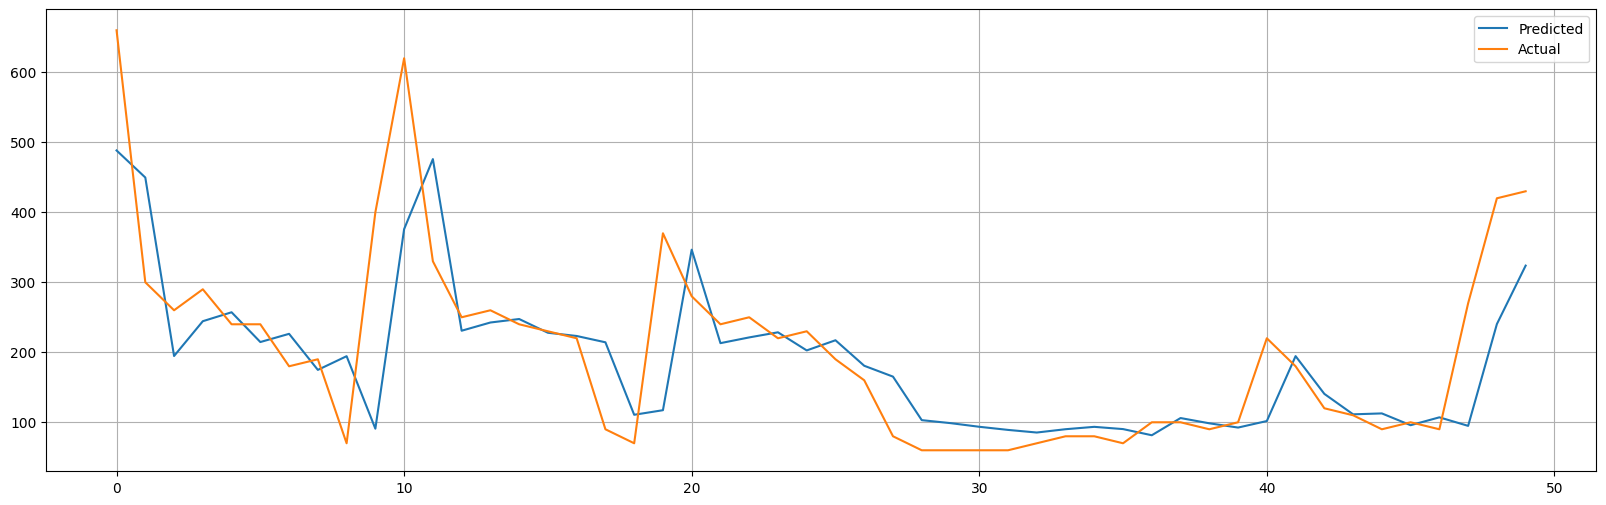

In [ ]:
# for convenience the plot is done just for a small window

window = 50
plt.figure(figsize=(20, 6))
pd.Series(predictions[-window:]).plot(label='Predicted')
pd.Series(test['Appliances'].values[-window:]).plot(label='Actual')
plt.legend()
plt.grid()
plt.show()

In [ ]:
print('MAE:', mean_absolute_error(test['Appliances'].values, predictions))

MAE: 27.047593644838997


In [38]:
model.order

(2, 0, 3)

Interestingly, when optimizing for the information criterion, we obtained an order of (2, 0, 3), suggesting an MA(3) component instead of 0.

Since our MAE with online retraining is approximately 27, we can now define error thresholds to experiment with a lighter retraining process—triggering retraining only when necessary.

In [40]:
thresholds = [25, 50, 100]
predictions_thresholds = {}
retrains = {}

for threshold in thresholds:
    print(f'Testing error threshold {threshold}:')
    predictions_thresholds[threshold] = []
    retrains[threshold] = 0
    not_retrained_buffer = []
    
    order = (2, 0, 3)
    model = pm.ARIMA(order=order)
    model.fit(train)
    
    for item in tqdm(test.values):
        not_retrained_buffer.append(item)
        prediction = model.predict(n_periods=1).tolist()[0]
        predictions_thresholds[threshold].append(prediction)
        
        error = abs(item - prediction)
        if error > threshold:
            # here we retrain, with the last values
            retrains[threshold] += 1
            model.update(not_retrained_buffer)
            not_retrained_buffer = []


Testing error threshold 25:


100%|██████████| 8173/8173 [2:04:25<00:00,  1.09it/s]  


Testing error threshold 50:


100%|██████████| 8173/8173 [1:14:55<00:00,  1.82it/s]  


Testing error threshold 100:


100%|██████████| 8173/8173 [48:59<00:00,  2.78it/s]  


In [ ]:
retrains

{25: 1710, 50: 958, 100: 596}

As expected, increasing the error threshold reduced the number of retraining instances.

Plot for threshold 25 , MAE: 27.612049869694147


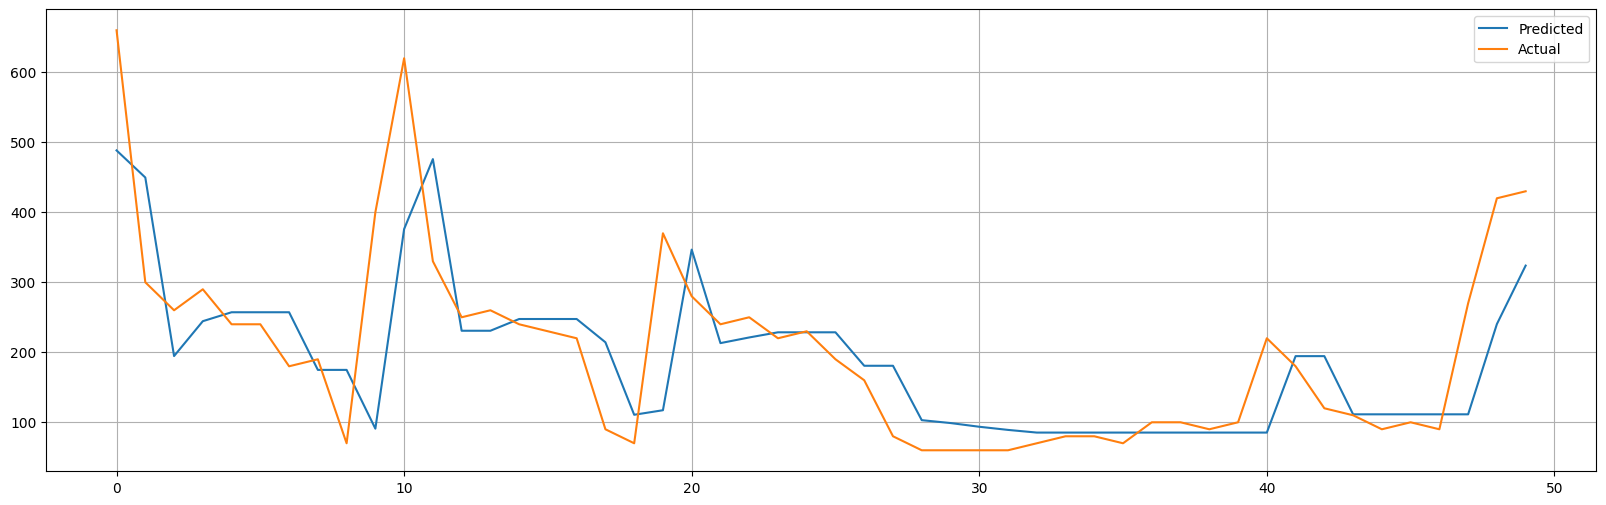

Plot for threshold 50 , MAE: 32.818617285916204


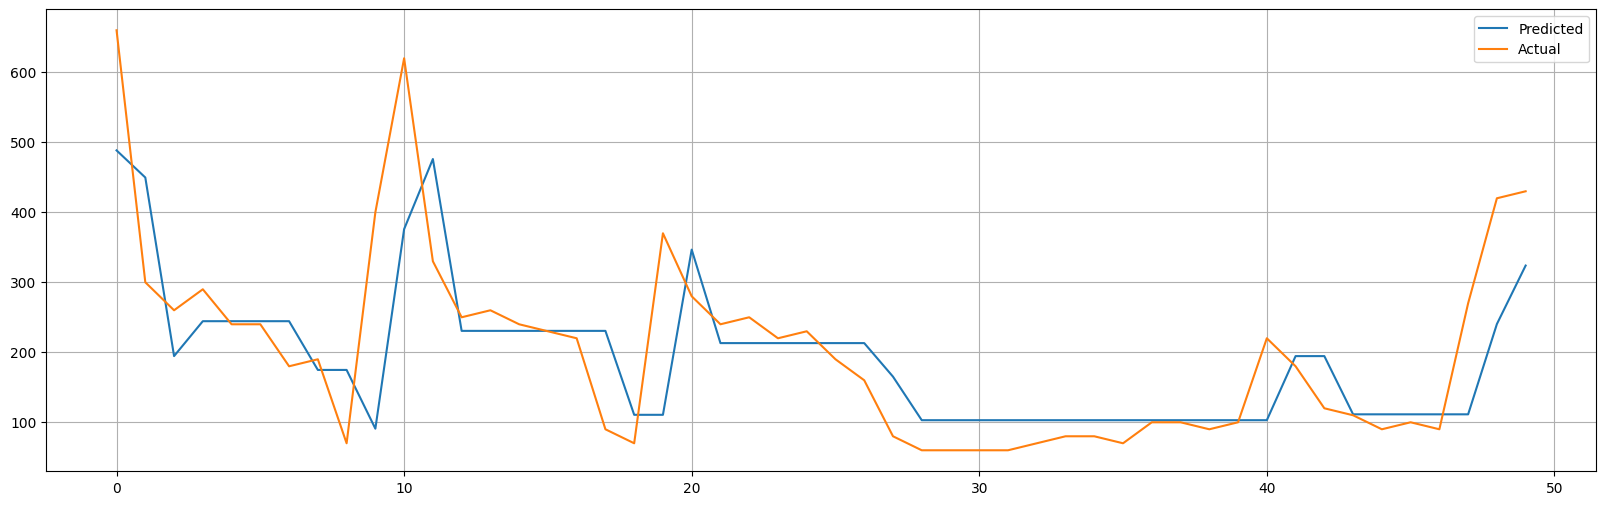

Plot for threshold 100 , MAE: 47.63314605929761


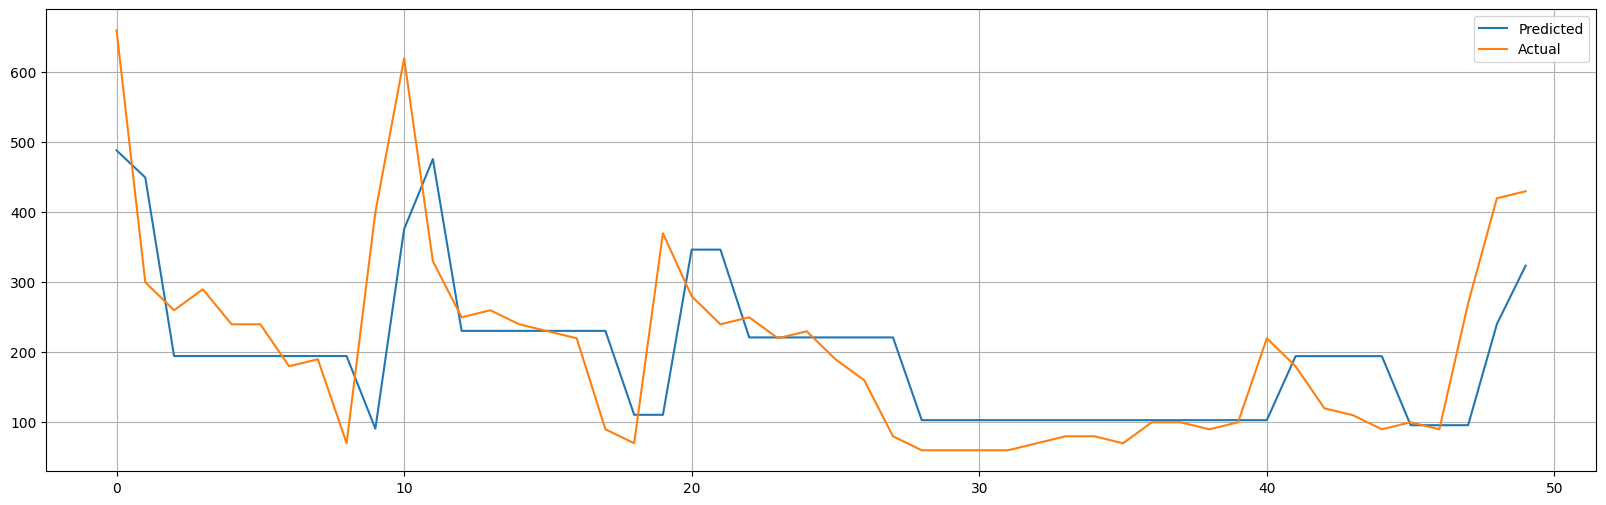

In [48]:
for threshold in thresholds:
    print('Plot for threshold', threshold, ", MAE:", mean_absolute_error(test['Appliances'].values, predictions_thresholds[threshold]))
    window = 50
    plt.figure(figsize=(20, 6))
    pd.Series(predictions_thresholds[threshold][-window:]).plot(label='Predicted')
    pd.Series(test['Appliances'].values[-window:]).plot(label='Actual')
    plt.legend()
    plt.grid()
    plt.show()

With an error threshold of 25 — slightly below the MAE of the online version — we observed a **2%** increase in MAE while reducing retraining by **80%**, making it a satisfactory result.

# Let's now add the linear trend

<Axes: xlabel='date'>

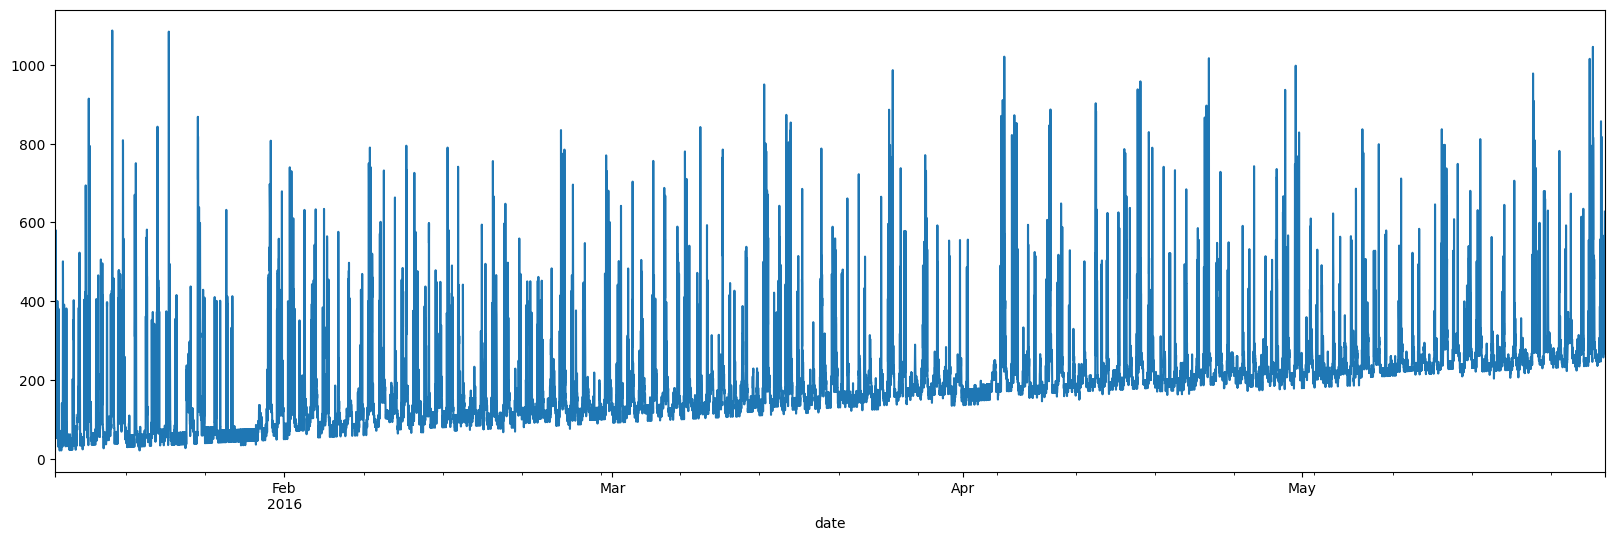

In [15]:
trended_ts = (ts['Appliances'] + np.arange(len(ts)) * 0.01) 
trended_ts.plot(figsize=(20, 6))

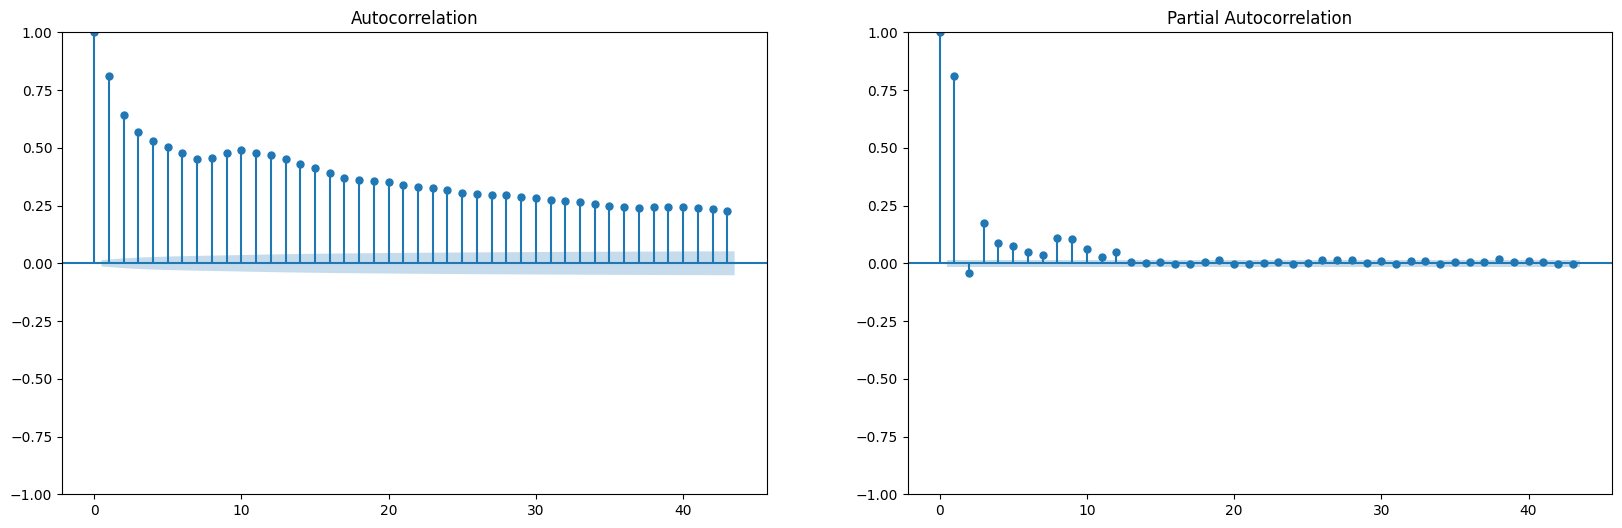

In [17]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_acf(trended_ts, ax=plt.gca())
plt.subplot(1, 2, 2)
plot_pacf(trended_ts, ax=plt.gca())
plt.show()

In [92]:
trended_train, trended_test = trended_ts.loc[ts.index < dt.datetime(2016, 4, 1)], trended_ts.loc[ts.index >= dt.datetime(2016, 4, 1)]

In [ ]:
model = pm.auto_arima(trended_train, d = 0) # so it's either AR or ARMA or MA (no differencing)
predictions_t = [] # prediction for the trended series

for item in tqdm(trended_test.values):
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions_t.append(prediction)
    model.update(item)

In [ ]:
trended_test

date
2016-04-01 00:00:00    117.810
2016-04-01 00:10:00    117.815
2016-04-01 00:20:00    117.820
2016-04-01 00:30:00    107.825
2016-04-01 00:40:00    107.830
                        ...   
2016-05-27 17:20:00    198.650
2016-05-27 17:30:00    188.655
2016-05-27 17:40:00    368.660
2016-05-27 17:50:00    518.665
2016-05-27 18:00:00    528.670
Name: Appliances, Length: 8173, dtype: float64

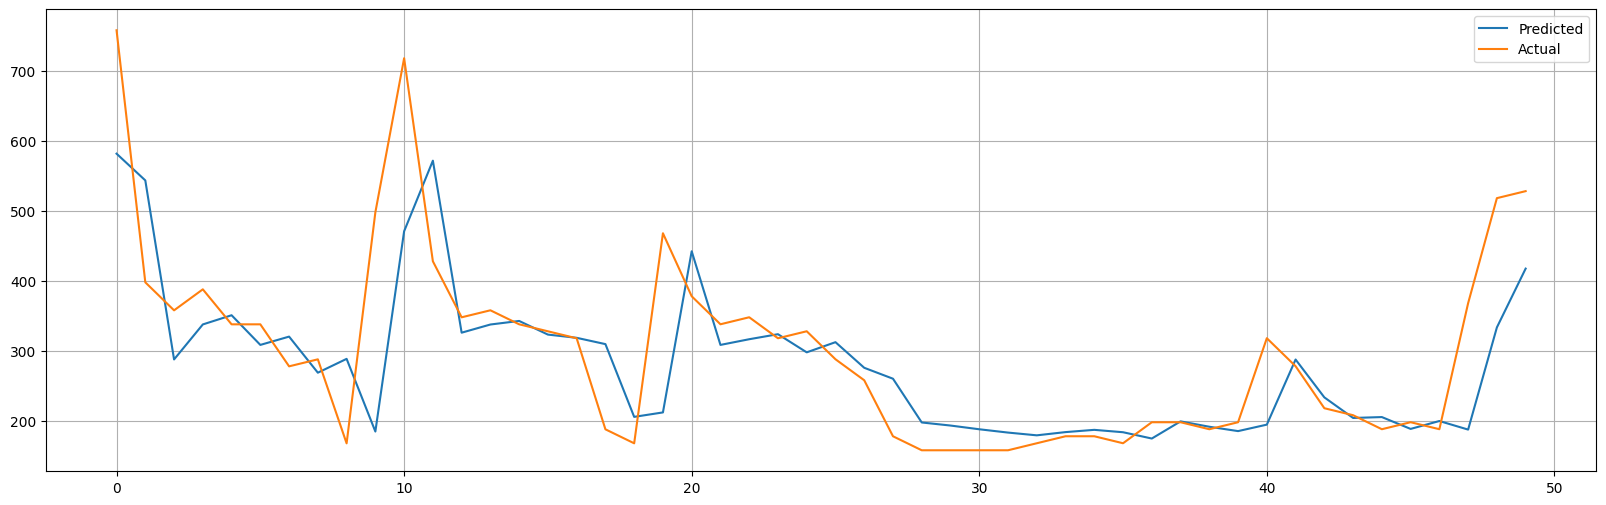

In [ ]:
window = 50
plt.figure(figsize=(20, 6))
pd.Series(predictions_t[-window:]).plot(label='Predicted')
pd.Series(trended_test.values[-window:]).plot(label='Actual')
plt.legend()
plt.grid()
plt.show()

In [97]:
order_t = model.order
print(order_t)

(2, 0, 3)


In [96]:
print('MAE:', mean_absolute_error(trended_test.values, predictions_t))

MAE: 86.42446583308644


In [98]:
thresholds = [90, 120, 150]
predictions_thresholds_t = {}
retrains_t = {}

for threshold in thresholds:
    print(f'Testing error threshold {threshold}:')
    predictions_thresholds_t[threshold] = []
    retrains_t[threshold] = 0
    not_retrained_buffer = []
    
    model = pm.ARIMA(order=order_t)
    model.fit(train)
    
    for item in tqdm(trended_test.values):
        not_retrained_buffer.append(item)
        prediction = model.predict(n_periods=1).tolist()[0]
        predictions_thresholds_t[threshold].append(prediction)
        
        error = abs(item - prediction)
        if error > threshold:
            # here we retrain, with the last values
            retrains_t[threshold] += 1
            model.update(not_retrained_buffer)
            not_retrained_buffer = []


Testing error threshold 90:


100%|██████████| 8173/8173 [58:42<00:00,  2.32it/s]  


Testing error threshold 120:


100%|██████████| 8173/8173 [47:39<00:00,  2.86it/s]  


Testing error threshold 150:


100%|██████████| 8173/8173 [40:53<00:00,  3.33it/s]  


In [99]:
retrains_t

{90: 649, 120: 521, 150: 431}

Plot for threshold 90 , MAE: 45.1074418366892


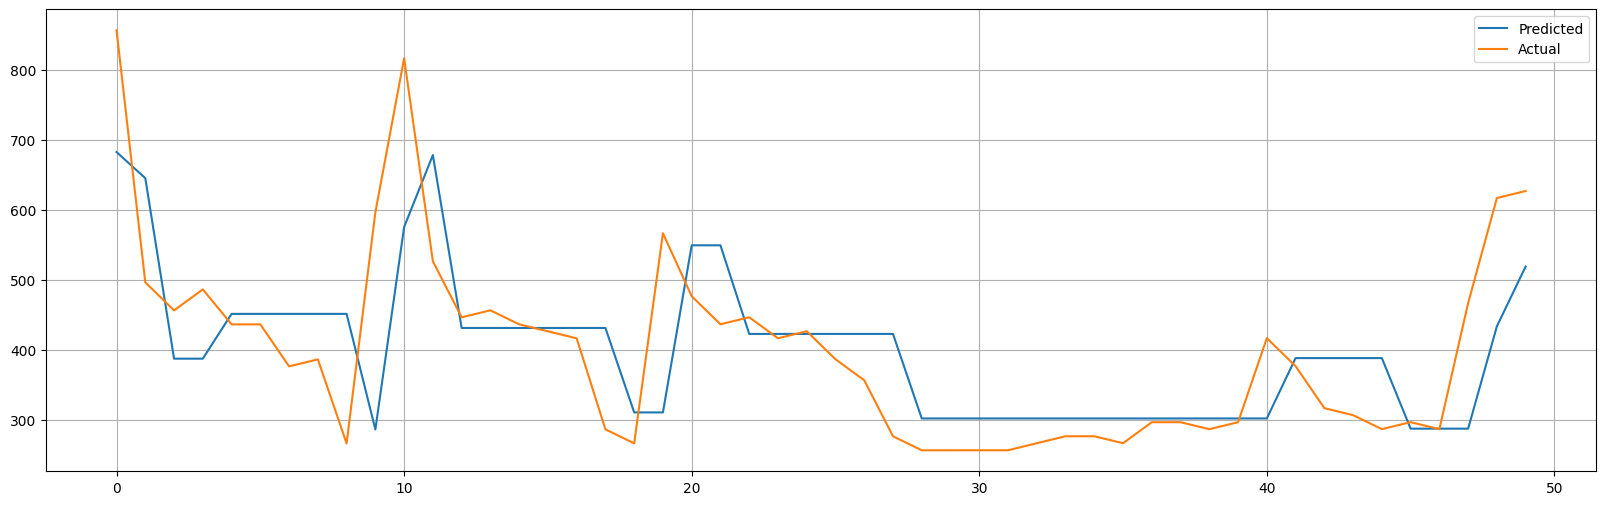

Plot for threshold 120 , MAE: 53.39405192530189


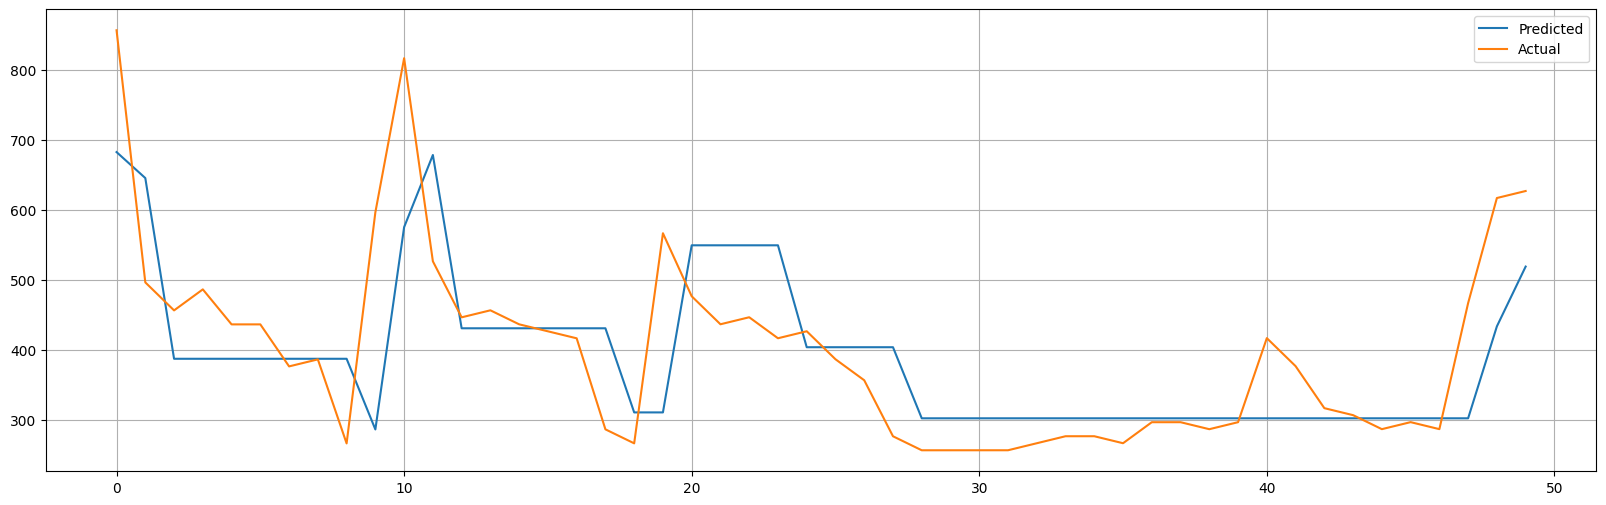

Plot for threshold 150 , MAE: 56.927961933459336


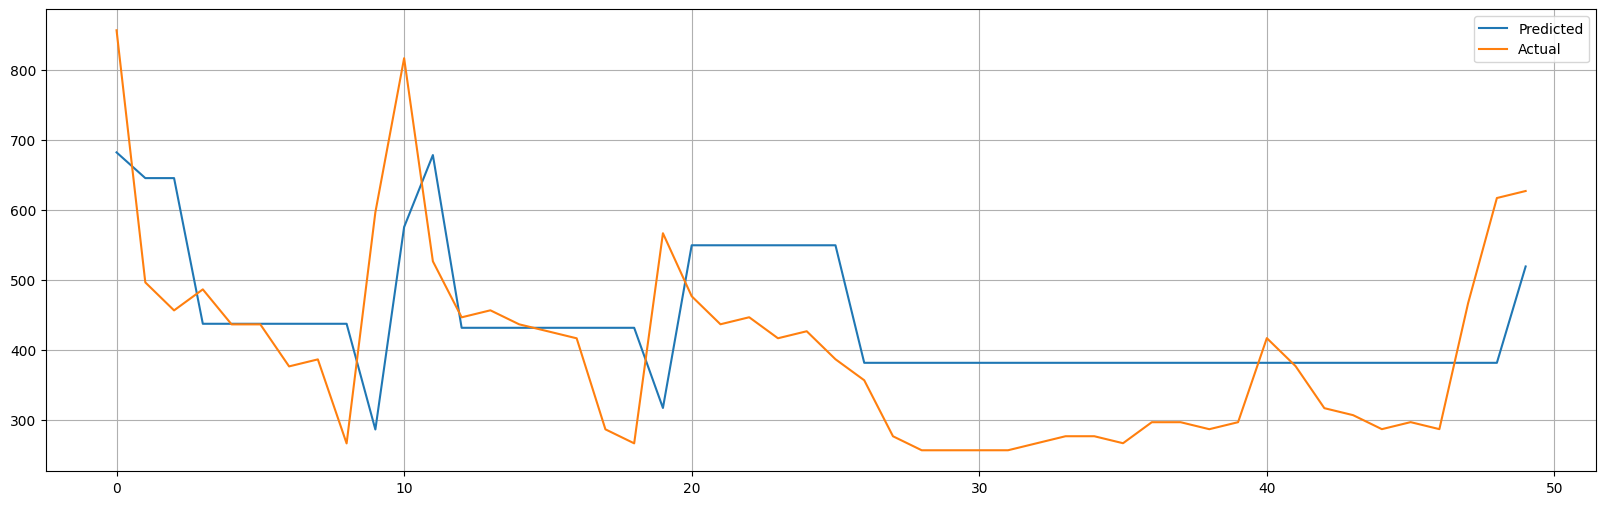

In [100]:
for threshold in thresholds:
    print('Plot for threshold', threshold, ", MAE:", mean_absolute_error(trended_test.values, predictions_thresholds_t[threshold]))
    window = 50
    plt.figure(figsize=(20, 6))
    pd.Series(predictions_thresholds_t[threshold][-window:]).plot(label='Predicted')
    pd.Series(trended_test.values[-window:]).plot(label='Actual')
    plt.legend()
    plt.grid()
    plt.show()

With full retraining, the MAE remains roughly the same. However, interestingly, increasing the error threshold for retraining results in smaller losses in the metric. This is likely because the subsequent values exhibit a trend that is well captured by the moving average component.

Now, out of curiosity, what happens if we include the 'd' component (which was not covered in the lecture) in the trended time series? Let's see if it leads to any improvement. For faster execution, we consider a threshold of 150.

(5, 1, 3)


100%|██████████| 8173/8173 [13:48<00:00,  9.87it/s]

Plot for threshold 150 , MAE: 62.10175225321577


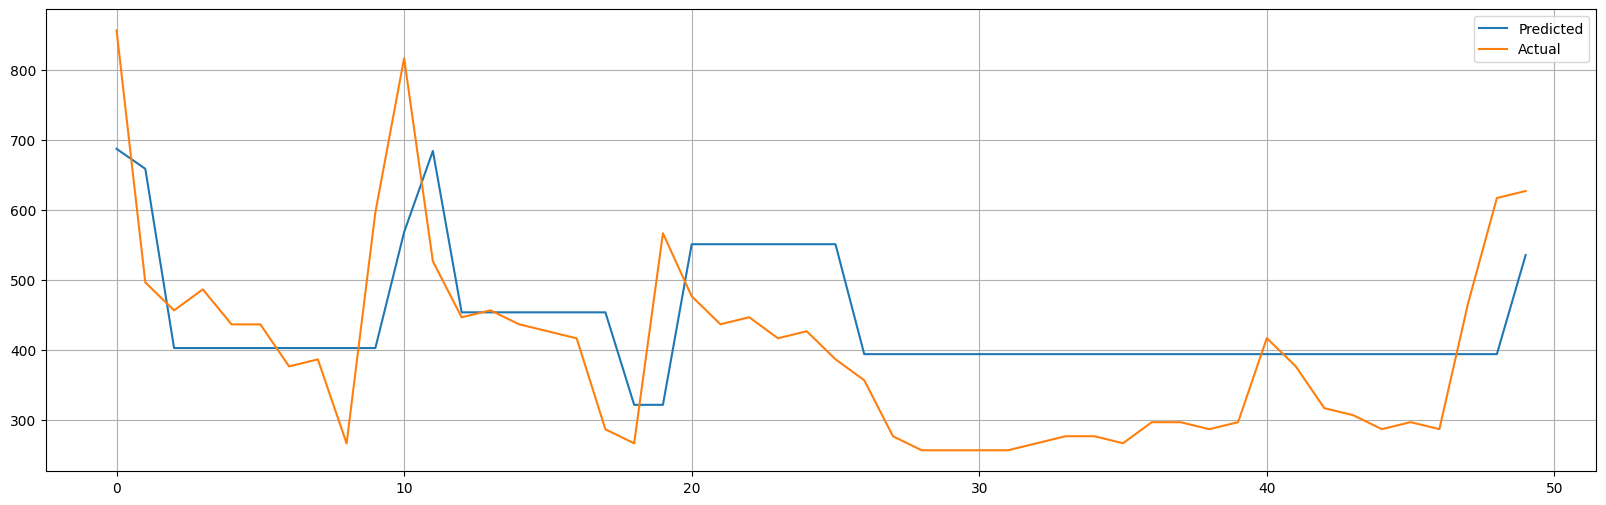

In [101]:
threshold = 150
predictions_thresholds_td = []
retrains_td = 0

model = pm.auto_arima(trended_train)
order_td = model.order

print(model.order)

not_retrained_buffer = []
    
    
for item in tqdm(trended_test.values):
    not_retrained_buffer.append(item)
    prediction = model.predict(n_periods=1).tolist()[0]
    predictions_thresholds_td.append(prediction)
        
    error = abs(item - prediction)
    if error > threshold:
        retrains_td += 1
        model.update(not_retrained_buffer)
        not_retrained_buffer = []
        
print('Plot for threshold', threshold, ", MAE:", mean_absolute_error(trended_test.values, predictions_thresholds_td))
window = 50
plt.figure(figsize=(20, 6))
pd.Series(predictions_thresholds_td[-window:]).plot(label='Predicted')
pd.Series(trended_test.values[-window:]).plot(label='Actual')
plt.legend()
plt.grid()
plt.show()

As we can see, including the 'd' component lowers the MAE. This is because differencing helps stabilize the mean of a non-stationary time series. As stated on Wikipedia: *"Differencing in statistics is a transformation applied to a non-stationary time series to make it stationary in the mean sense (i.e., to remove the non-constant trend), but it does not affect the non-stationarity of the variance or autocovariance."*  